In [1]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ddpg_agent_testing import DDPGMultiAgent
from utils import VisWriter, save_to_txt
writer = VisWriter(vis=False)

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
agent = DDPGMultiAgent(state_size, action_size, num_agents, writer=writer, random_seed=10, 
                        dirname="output", print_every=100, model_path=None)

INFO:ddpg_multi:Initialised with random seed: 10


In [6]:
def ddpg(env, brain_name, num_agents, agent, writer, n_episodes, max_t, print_every=100, stop_on_solve=True):

    best_score = -np.inf
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment  
        agent.reset()                                             # reset the agents     
        states = env_info.vector_observations                      # get the current state for each agent 
        episode_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)            
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            episode_scores += np.array(rewards)                # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        episode_score  = np.max(episode_scores)  # Consider the maximum score amongs all Agents
        scores_deque.append(episode_score)
        scores.append(episode_score)
        avg_score = np.mean(scores_deque)
                
        print('\rEpisode {}\tAverage Score: {:.2f}\tCurrent score: {:.2f}'.format(i_episode, avg_score, episode_score), end="")
        if i_episode>0 and i_episode % 100 == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, avg_score, episode_score))
        
        if (i_episode > 99) and (avg_score >=0.5):
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
            break
            
    return scores

In [7]:
scores = ddpg(env, brain_name, num_agents, agent, writer=writer, n_episodes=10000, max_t=100, stop_on_solve=True)

Episode: 100	Average Score: 0.00	Current Score: 0.00
Episode: 200	Average Score: 0.00	Current Score: 0.00
Episode: 300	Average Score: 0.00	Current Score: 0.00
Episode: 400	Average Score: 0.00	Current Score: 0.00
Episode: 500	Average Score: 0.00	Current Score: 0.00
Episode: 600	Average Score: 0.00	Current Score: 0.00
Episode: 700	Average Score: 0.01	Current Score: 0.00
Episode: 800	Average Score: 0.01	Current Score: 0.00
Episode: 900	Average Score: 0.04	Current Score: 0.00
Episode: 1000	Average Score: 0.02	Current Score: 0.00
Episode: 1100	Average Score: 0.02	Current Score: 0.00
Episode: 1200	Average Score: 0.01	Current Score: 0.00
Episode: 1300	Average Score: 0.01	Current Score: 0.00
Episode: 1400	Average Score: 0.01	Current Score: 0.00
Episode: 1500	Average Score: 0.01	Current Score: 0.00
Episode: 1600	Average Score: 0.01	Current Score: 0.10
Episode: 1700	Average Score: 0.04	Current Score: 0.00
Episode: 1800	Average Score: 0.05	Current Score: 0.09
Episode: 1900	Average Score: 0.06	Cur

In [8]:
print(scores)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000149011612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

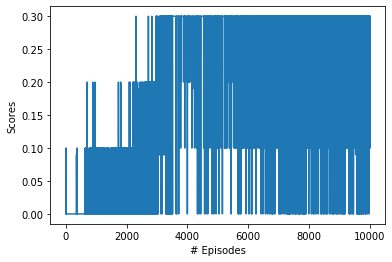

In [9]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.savefig('output/ddpg_scores_plot.png')
plt.show()